In [11]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.io
import pandas as pd
from mne import stats
import mne
from IPython.utils import io
import pickle
import os
from os.path import exists

In [12]:
epochs_dir = 'C:\AnatArzData\YKM_data\epochs_and_evoked_allSubs'
prepro_name = "referenced"
import_type = "5Electorodes_plainEEGLAB"
trial_exclution_str = "_excOulierTrials-3.5" #"_excOulierTrials-2.5"

## Import epochs

In [13]:
class AuxFuncs:
    def __init__(self, import_path):
        ## import epochs data and meta-data
        with open(import_path, 'rb') as file:
            [allEvents_df, allEpochs_perCond, cfg] = pickle.load(file)

        self.allEpochs_perCond = allEpochs_perCond
        self.allEvents_df = allEvents_df
        self.cfg = cfg
        self.info,self.montage = self.get_subject_info()

        self.max_freq =cfg['sample_freq']/2 # for tfr
        self.times = cfg['times']
        self.time0_i = np.where(self.times==0)[0][0]
        self.hz_y = np.fft.rfftfreq(len(self.times[self.time0_i:]), 1.0/cfg['sample_freq'])


    def get_subject_info(self, example_subject = '32'):
        subject_setfile_wake_n = f'{self.cfg["set_files_dir"]}\s_{example_subject}_wake_night_referenced.set'
        output_file_path = f"{self.cfg['outputs_dir_path'] }/epochs_Wn_s{example_subject}_file"

        if exists(output_file_path):
            with open(output_file_path, 'rb') as config_dictionary_file:
                epochs_Wn_example_sub = pickle.load(config_dictionary_file)
                #print(epochs_Wn_example_sub)
        else:
            epochs_Wn_example_sub = mne.io.read_epochs_eeglab(subject_setfile_wake_n, events=None, event_id=None,eog=(),verbose=None, uint16_codec=None)
            with open(output_file_path, 'wb') as epochs_Wn_s_example_file:
                pickle.dump(epochs_Wn_example_sub, epochs_Wn_s_example_file)

        montage = mne.channels.make_standard_montage('GSN-HydroCel-128')
        epochs_Wn_example_sub_piked = epochs_Wn_example_sub.pick_channels(self.cfg['ch_names'])
        epochs_Wn_example_sub_monatged = epochs_Wn_example_sub_piked.set_montage(montage)
        epochs_info = epochs_Wn_example_sub_monatged.info
        return epochs_info, epochs_Wn_example_sub_monatged

    def getEpochsPerCond(self,cond_df,dataset):
        df_minTrials = cond_df[(cond_df.SamplesCount > 0)] # discard cond with 0 enough samples
        keys = (str(key) for key in df_minTrials.Cond_id)
        epochs_allSamples = {str_key: dataset[str_key] for str_key in keys}
        return df_minTrials, epochs_allSamples

    # output: [#conds, #elect, #times]
    def getEvokedPerCondAndElectd(self, constraints,dataset, y_ax,outputType='array', tmin=-0.1, baseline=(None, 0)):
        curr_df = self.allEvents_df.copy()
        # apply constraints
        for key in constraints: curr_df = curr_df[(curr_df[key] == constraints[key])]

        conds_df, epochsPerCond = self.getEpochsPerCond(curr_df,dataset)
        evoked_perCond_andElectd = np.zeros((len(epochsPerCond),np.size(self.cfg['electrodes']),np.size(y_ax)))

        for cond_i, cond in enumerate(epochsPerCond):
            evoked_perCond_andElectd[cond_i] = np.squeeze(np.nanmean(epochsPerCond[cond], axis=2))

        if outputType =='array':
            return conds_df, evoked_perCond_andElectd
        if outputType =='mne':
            mne_epochs = mne.EpochsArray(evoked_perCond_andElectd, self.info, tmin=tmin, baseline=baseline)
            return conds_df, mne_epochs

import_path = f'{epochs_dir}\\{import_type}{trial_exclution_str}.pkl'
aux = AuxFuncs(import_path)

allEpochs_perCond = aux.allEpochs_perCond
allEvents_df = aux.allEvents_df
cfg = aux.cfg
times = aux.times
time0_i = aux.time0_i

n_permutations = 10000 # default 1k for testing. For reals - 10K

fig_output_dir = f"{cfg['outputs_dir_path']}/erp_clusterPerm"
if not os.path.exists(fig_output_dir):
    os.mkdir(fig_output_dir)

## Clusters and evoked funcs

In [14]:
""" create a df with the clusters details"""
#bonferroni correction (0.05/6)=0.0083
def get_clusters_dfs(contrasts, times, cluster_res,p_crit = 0.05):
    comparison = []
    p_values = []
    start = []
    end = []
    for s,pair in enumerate(contrasts):
        comparison_level = []
        start_level = []
        end_level = []

        contrast_str = f"{pair[0]}_{pair[1]}"
        curr_cluster_equal = cluster_res[contrast_str]['clusters_equal']
        curr_cluster_equal_pv = cluster_res[contrast_str]['cluster_equal_pv']
        cluster_res[contrast_str]['cl_'] = []

        if len(curr_cluster_equal)==0: continue
        for i_clu, clu_idx in enumerate(curr_cluster_equal):
            clu_idx = clu_idx[0]
            comparison_level.append(contrast_str)
            start_level.append(times[clu_idx[0]])
            end_level.append(times[clu_idx[-1]])
            if curr_cluster_equal_pv[i_clu] <= p_crit:
                cluster_res[contrast_str]['cl_'].append((times[clu_idx[0]],times[clu_idx[-1]]))
        comparison.append(comparison_level)
        start.append(start_level)
        end.append(end_level)
        p_values.append(list(curr_cluster_equal_pv))

    # Create dataframe
    comparison = np.concatenate(comparison)
    p_values = np.concatenate(p_values)
    start = np.concatenate(start)
    end = np.concatenate(end)
    d = {'Comparison': comparison,'p-value': p_values,'start (ms)': start,'end (ms)': end}
    clusters = pd.DataFrame(data=d)

    sig_clus = clusters.drop(clusters[clusters['p-value']>p_crit].index)
    return clusters, sig_clus

In [15]:
def get_contrasts_ax(ax, contrasts, contrastsColors,cluster_res):
    for s,contrast in enumerate(contrasts):
        contrast_str = f"{contrast[0]}_{contrast[1]}"
        curr_cl = cluster_res[contrast_str]['cl_']
        for i in range(len(curr_cl)):
            ax.plot([curr_cl[i][0],curr_cl[i][1]], [-2-(s*0.1),-2-(s*0.1)],'-', color = contrastsColors[s][0], linewidth = 2.5)
            ax.plot([curr_cl[i][0],curr_cl[i][1]], [-2-(s*0.1),-2-(s*0.1)],'--', color = contrastsColors[s][1], linewidth = 2.5)

In [16]:
def stat_fun_wilcox(X):
    result = scipy.stats.wilcoxon(X)
    return result.statistic

def getClustersPerConditions(startTime_i, contrastTypeName,contrasts,conditions,test_per_voxel='ttest'):
    if test_per_voxel=='ttest':
        test_per_voxel = mne.stats.ttest_1samp_no_p
    else:
        test_per_voxel = stat_fun_wilcox

    cluster_subjs = [] # list (size subs) of list (size pairs) of 138 samps each
    for s,subject in enumerate(cfg['subs']):
        cluster_pair = []
        conditions['Subject'] = subject
        for pair in contrasts: # averaged across trials
            conditions[contrastTypeName] = pair[0]
            conds_df, evoked_perCond_andElectd = aux.getEvokedPerCondAndElectd(conditions,allEpochs_perCond, cfg['times'],outputType='array')
            meanOverTrials_first = np.nanmean(evoked_perCond_andElectd,axis=0)

            conditions[contrastTypeName] = pair[1]
            conds_df, evoked_perCond_andElectd = aux.getEvokedPerCondAndElectd(conditions,allEpochs_perCond, cfg['times'],outputType='array')
            meanOverTrials_sec = np.nanmean(evoked_perCond_andElectd,axis=0)

            diff_sub_pair_mean = np.nanmean(meanOverTrials_first - meanOverTrials_sec, axis=0)
            if ~np.all(diff_sub_pair_mean==0) and ~np.isnan(diff_sub_pair_mean).any():
                cluster_pair.append(diff_sub_pair_mean)
        cluster_subjs.append(cluster_pair)

    """ Perform cluster permutation (paired t-test) """
    cluster_res={}
    for n, pair in enumerate(contrasts):
        curr_pair_res ={}
        curr_dif_arr = np.asarray(cluster_subjs)[:,n,startTime_i:]
        curr_pair_res['T_obs'], curr_pair_res['clusters_equal'],curr_pair_res['cluster_equal_pv'],curr_pair_res['H0'] = stats.permutation_cluster_1samp_test(curr_dif_arr,n_permutations=1000, stat_fun=test_per_voxel)

        cluster_res[f"{pair[0]}_{pair[1]}"] = curr_pair_res

    return cluster_res

def getClustersPerConditions_perSubject(subject, startTime_i, contrastTypeName,contrasts,conditions,test_per_voxel='ttest'):
    if test_per_voxel=='ttest':
        test_per_voxel = mne.stats.ttest_1samp_no_p
    else:
        test_per_voxel = stat_fun_wilcox
    
    for pair in contrasts: # averaged across trials
            conditions[contrastTypeName] = pair[0]    
            __, epochs_cond1 = aux.getEpochsPerCond(conditions,dataset=allEpochs_perCond)
            mne_epochs_cond1 = mne.EpochsArray(epochs_cond1, aux.info, tmin=aux.tmin, baseline=aux.baseline)
            
            conditions[contrastTypeName] = pair[1]
            __, epochs_cond2 = aux.getEpochsPerCond(conditions,dataset=allEpochs_perCond)
            mne_epochs_cond2 = mne.EpochsArray(epochs_cond2, aux.info, tmin=aux.tmin, baseline=aux.baseline)
            
    """ Perform cluster permutation (paired t-test) """
    cluster_res={}
    for n, pair in enumerate(contrasts):
        curr_pair_res ={}
        curr_dif_arr = np.asarray(cluster_subjs)[:,n,startTime_i:]
        curr_pair_res['T_obs'], curr_pair_res['clusters_equal'],curr_pair_res['cluster_equal_pv'],curr_pair_res['H0'] = stats.permutation_cluster_test(curr_dif_arr,n_permutations=n_permutations, stat_fun=test_per_voxel)

        cluster_res[f"{pair[0]}_{pair[1]}"] = curr_pair_res



    cluster_subjs = [] # list (size subs) of list (size pairs) of 138 samps each
    for s,subject in enumerate(cfg['subs']):
        cluster_pair = []
        conditions['Subject'] = subject
        for pair in contrasts: # averaged across trials
            conditions[contrastTypeName] = pair[0]
            conds_df, evoked_perCond_andElectd = aux.getEvokedPerCondAndElectd(conditions,allEpochs_perCond, cfg['times'],outputType='array')
            meanOverTrials_first = np.nanmean(evoked_perCond_andElectd,axis=0)

            conditions[contrastTypeName] = pair[1]
            conds_df, evoked_perCond_andElectd = aux.getEvokedPerCondAndElectd(conditions,allEpochs_perCond, cfg['times'],outputType='array')
            meanOverTrials_sec = np.nanmean(evoked_perCond_andElectd,axis=0)

            diff_sub_pair_mean = np.nanmean(meanOverTrials_first - meanOverTrials_sec, axis=0)
            if ~np.all(diff_sub_pair_mean==0) and ~np.isnan(diff_sub_pair_mean).any():
                cluster_pair.append(diff_sub_pair_mean)
        cluster_subjs.append(cluster_pair)

    """ Perform cluster permutation (paired t-test) """
    cluster_res={}
    for n, pair in enumerate(contrasts):
        curr_pair_res ={}
        curr_dif_arr = np.asarray(cluster_subjs)[:,n,startTime_i:]
        curr_pair_res['T_obs'], curr_pair_res['clusters_equal'],curr_pair_res['cluster_equal_pv'],curr_pair_res['H0'] = stats.permutation_cluster_1samp_test(curr_dif_arr,n_permutations=1000, stat_fun=test_per_voxel)

        cluster_res[f"{pair[0]}_{pair[1]}"] = curr_pair_res

    return cluster_res

In [40]:
# def get_evokedPerCond_ax_mneFunc(ax1,df,condName : str, condVaribles, filterConds, graphColors):
#     evokeds = {}
#     for s,subject in enumerate(subs):
#         evokeds[s] = {}
#         filterConds['Subject'] = subject
#         for val in condVaribles:
#             filterConds[condName] = val
#             curr_subAndCond_electrOverTime = get_avgOverTrials(df, filterConds)
#             curr_subAndCond_electrOverTime /= 1e6
#             evokeds[s][val] = mne.EvokedArray(curr_subAndCond_electrOverTime,info,tmin=-0.1)
#
#     # Edit the data to mne plot format
#     evokeds_mnePlotFormat = {}
#     for val in condVaribles:
#         evokeds_mnePlotFormat[val] = []
#         for sub_i in range(len(subs)):
#             evokeds_mnePlotFormat[val].append(evokeds[sub_i][val])
#
#     plot_compare_evokeds(evokeds_mnePlotFormat,combine = 'mean',colors=graphColors,
#                          axes=ax1,show=False,truncate_xaxis=False, truncate_yaxis=False,
#                          show_sensors = False , legend='upper left')
def applyDesign(fig,ax,title='',y_lims=[-3,3]):
    fig.patch.set_facecolor('xkcd:white')
    ax.set_facecolor('silver')
    ax.set_title(title,fontsize = 18, fontweight = 'bold')
    ax.legend(loc = 'upper left',prop={'size': 10})
    ax.axvline(x=0,color='gray', linestyle='--',label ="_nolegend_")
    ax.axhline(y=0, color='gray', linestyle='-',label ="_nolegend_")
    ax.set_ylabel('\u03BCV', fontsize = 16, fontweight = 'bold')
    ax.tick_params(axis='both', which='major', labelsize=14)
    ax.set_xlabel('Time (ms)', fontsize = 16, fontweight = 'bold')
    ax.set_xlim([-100,450])
    ax.set_ylim(y_lims)
    ax.text(-0.02, y_lims[1], 'stimulus', rotation=90, va='center', fontsize = 13)

def get_evokedPerCond_ax(ax1,df,condName : str, condVaribles, filterConds, graphColors):
    all_evokeds = np.zeros((len(cfg['subs']),len(condVaribles) , len(times)))
    for s,subject in enumerate(cfg['subs']):
        filterConds['Subject'] = subject
        for v,val in enumerate(condVaribles):
            filterConds[condName] = val

            conds_df, evoked_perCond_andElectd = aux.getEvokedPerCondAndElectd(filterConds,allEpochs_perCond, cfg['times'],outputType='array')
            curr_subAndCond_electrOverTime = np.nanmean(evoked_perCond_andElectd,axis=0)
            all_evokeds[s,v,:] = np.nanmean(curr_subAndCond_electrOverTime,axis=0)

    mean_ = np.nanmean(all_evokeds,axis=0)
    std_ = np.nanstd(all_evokeds/np.sqrt(all_evokeds.shape[0]),axis=0)

    ax1.plot(times,mean_.T)
    for v,val in enumerate(condVaribles):
        ax1.fill_between(times,mean_[v]+std_[v] ,mean_[v]-std_[v], color=graphColors[v],alpha=0.1,label ="_nolegend_")
        ax1.plot(times,mean_[v],label = condVaribles[v],color=graphColors[v])
        print(f"v={v},val={val}") # \nmean:{mean_}\nstd{std_}
    return ax1


# Resutls

,Comparison,p-value,start (ms),end (ms)
0,Wn_N2,0.258,0,4
1,Wn_N2,0.132,416,448
2,Wn_N2,0.001,16,332
3,Wn_N3,0.323,0,0
4,Wn_N3,0.035,380,448
5,Wn_N3,0.001,16,320
6,Wn_REM,0.143,420,448
7,Wn_REM,0.001,12,104
8,Wn_REM,0.001,128,348
9,N2_N3,0.074,392,448


,Comparison,p-value,start (ms),end (ms)
2,Wn_N2,0.001,16,332
4,Wn_N3,0.035,380,448
5,Wn_N3,0.001,16,320
7,Wn_REM,0.001,12,104
8,Wn_REM,0.001,128,348
12,N2_REM,0.004,56,132
13,N2_REM,0.042,224,292
16,REM_N3,0.030,364,448
17,REM_N3,0.010,68,164
18,REM_N3,0.037,196,280


v=0,val=Wn
v=1,val=N2
v=2,val=N3
v=3,val=REM


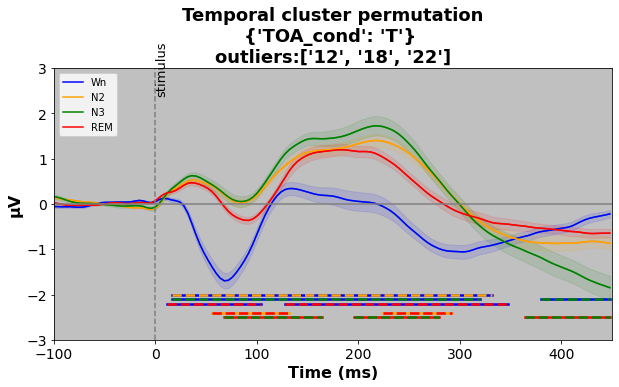

,Comparison,p-value,start (ms),end (ms)
0,Wn_REM,0.003,28,224
1,Wn_REM,0.002,240,448
2,N2_REM,0.038,4,84
3,N2_REM,0.079,104,160
4,N2_REM,0.002,176,448
5,REM_N3,0.333,212,220
6,REM_N3,0.190,232,264
7,REM_N3,0.160,388,424


,Comparison,p-value,start (ms),end (ms)
0,Wn_REM,0.003,28,224
1,Wn_REM,0.002,240,448
2,N2_REM,0.038,4,84
4,N2_REM,0.002,176,448


v=0,val=Wn
v=1,val=N2
v=2,val=N3
v=3,val=REM


<Figure size 432x288 with 0 Axes>

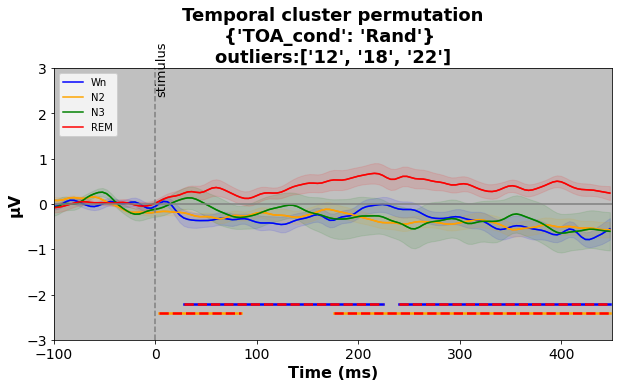

,Comparison,p-value,start (ms),end (ms)
0,Wn_N2,0.281,112,128
1,Wn_REM,0.401,252,260
2,Wn_REM,0.438,292,296
3,Wn_REM,0.092,356,404
4,N2_N3,0.134,404,448
5,N2_REM,0.061,208,264
6,N2_REM,0.261,288,304
7,REM_N3,0.235,256,272
8,REM_N3,0.243,288,304
9,REM_N3,0.235,312,328


,Comparison,p-value,start (ms),end (ms)


v=0,val=Wn
v=1,val=N2
v=2,val=N3
v=3,val=REM


<Figure size 432x288 with 0 Axes>

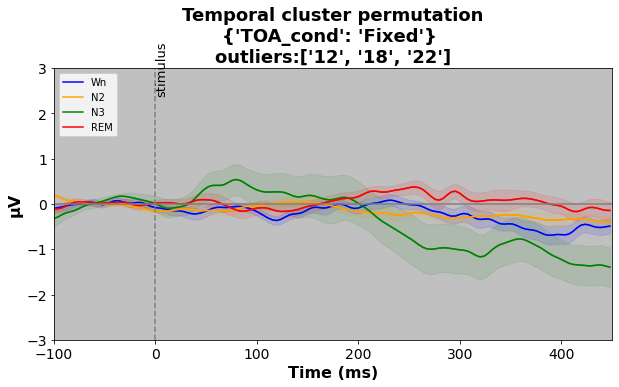

<Figure size 432x288 with 0 Axes>

In [39]:
contrasts = [['Wn','N2'],['Wn','N3'],['Wn','REM'],['N2','N3'],['N2','REM'],['REM','N3']]
contrastsColors = [['blue', 'orange'], ['blue', 'green'], ['blue', 'red'], ['orange', 'green'], ['orange', 'red'], ['red', 'green']]
contrastTypeName = 'Vigilance'
contrast_seperateVal = ['Wn','N2','N3','REM']
contrasts_sep_colors = ['blue', 'orange', 'green', 'red']

for TOA_cond in ['T','Rand','Fixed']:
    filters= {'TOA_cond':TOA_cond}
    filters_string = f"{filters}"

    ### get df cluster info
    with io.capture_output() as captured: # suppress output
        cluster_res = getClustersPerConditions(time0_i,contrastTypeName,contrasts,filters,test_per_voxel='ttest')
        all_clust_df, sig_clust_df = get_clusters_dfs(contrasts,times[time0_i:],cluster_res)
    display(all_clust_df)
    display(sig_clust_df)

    ### plot clusters
    fig,ax1 = plt.subplots(1, 1, figsize=(10, 5))
    fig.patch.set_facecolor('xkcd:white')
    ax1 = get_evokedPerCond_ax(ax1, allEvents_df, contrastTypeName, contrast_seperateVal, filters, contrasts_sep_colors)
    get_contrasts_ax(ax1, contrasts, contrastsColors,cluster_res)
    applyDesign(fig, ax1,f'Temporal cluster permutation\n{filters_string} \noutliers:{cfg["outlier_subs"]}')
    plt.show()
    plt.savefig(f'{fig_output_dir}/{TOA_cond}_allValidSubs_perVigi_5CentElect_wilcox.png')

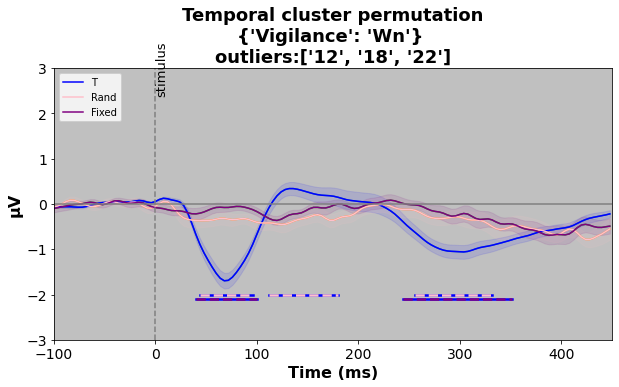

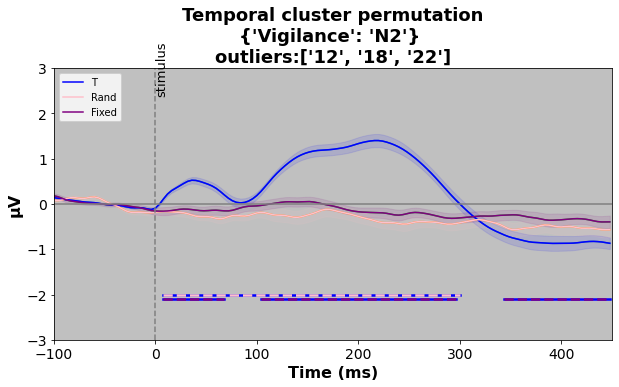

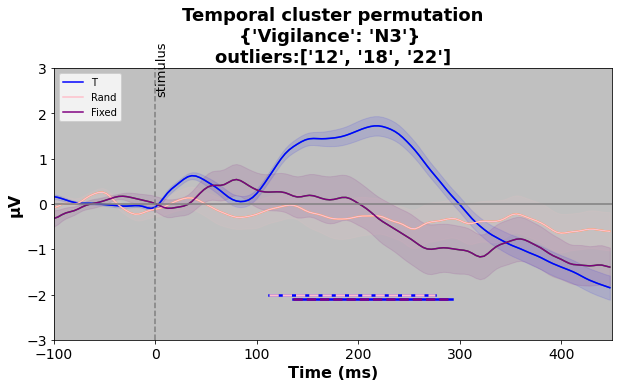

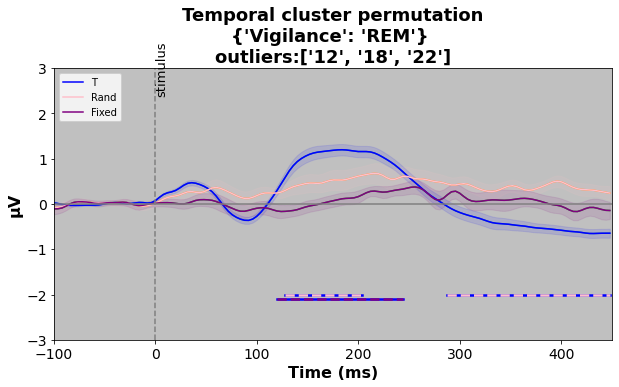

In [20]:
contrasts = [['T','Rand'],['T','Fixed'],['Rand','Fixed']]
contrastsColors = [ ['blue', 'pink'], ['blue', 'purple'],['purple', 'pink']]
contrastTypeName = 'TOA_cond'
contrast_seperateVal = ['T','Rand','Fixed']
contrasts_sep_colors = ['blue','pink','purple']

for vigilance in cfg['vigi_states']:
    filters= {'Vigilance':vigilance}
    filters_string = f"{filters}"

    ### get df cluster info
    with io.capture_output() as captured: # suppress output
        cluster_res = getClustersPerConditions(time0_i,contrastTypeName,contrasts,filters)
        all_clust_df, sig_clust_df = get_clusters_dfs(contrasts,times[time0_i:],cluster_res)
        display(all_clust_df)
        display(sig_clust_df)

    ### plot clusters
    fig,ax1 = plt.subplots(1, 1, figsize=(10, 5))
    ax1 = get_evokedPerCond_ax(ax1, allEvents_df, contrastTypeName, contrast_seperateVal, filters, contrasts_sep_colors)
    get_contrasts_ax(ax1, contrasts, contrastsColors,cluster_res)
    applyDesign(fig,ax1,f'Temporal cluster permutation\n{filters_string} \noutliers:{cfg["outlier_subs"]}')
    plt.savefig(f'{fig_output_dir}/{vigilance}_allValidSubs_perTOACond_5CentElect.png')

## ClusterPermu per subject

,Comparison,p-value,start (ms),end (ms)
0,Wn_N2,0.270,0,4
1,Wn_N2,0.137,416,448
2,Wn_N2,0.001,16,332
3,Wn_N3,0.311,0,0
4,Wn_N3,0.037,380,448
5,Wn_N3,0.001,16,320
6,Wn_REM,0.130,420,448
7,Wn_REM,0.002,12,104
8,Wn_REM,0.001,128,348
9,N2_N3,0.083,392,448


,Comparison,p-value,start (ms),end (ms)
2,Wn_N2,0.001,16,332
4,Wn_N3,0.037,380,448
5,Wn_N3,0.001,16,320
7,Wn_REM,0.002,12,104
8,Wn_REM,0.001,128,348
12,N2_REM,0.010,56,132
13,N2_REM,0.036,224,292
16,REM_N3,0.043,364,448
17,REM_N3,0.014,68,164


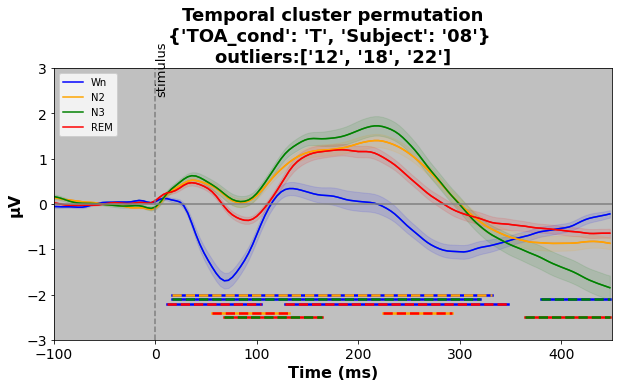

,Comparison,p-value,start (ms),end (ms)
0,Wn_N2,0.342,168,180
1,Wn_N3,0.266,32,48
2,Wn_REM,0.056,24,72
3,Wn_REM,0.009,112,220
4,Wn_REM,0.222,260,280
5,Wn_REM,0.264,304,320
6,Wn_REM,0.008,336,448
7,N2_REM,0.050,0,68
8,N2_REM,0.024,188,308
9,N2_REM,0.018,340,448


,Comparison,p-value,start (ms),end (ms)
3,Wn_REM,0.009,112,220
6,Wn_REM,0.008,336,448
7,N2_REM,0.050,0,68
8,N2_REM,0.024,188,308
9,N2_REM,0.018,340,448


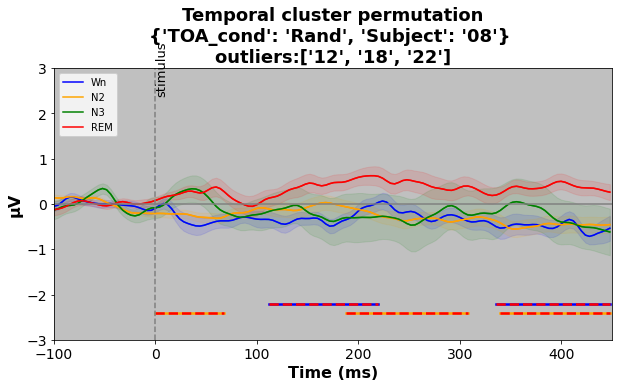

,Comparison,p-value,start (ms),end (ms)
0,Wn_N2,0.275,112,128
1,Wn_REM,0.413,252,260
2,Wn_REM,0.455,292,296
3,Wn_REM,0.077,356,404
4,N2_N3,0.122,404,448
5,N2_REM,0.075,208,264
6,N2_REM,0.267,288,304
7,REM_N3,0.199,256,272
8,REM_N3,0.208,288,304
9,REM_N3,0.200,312,328


,Comparison,p-value,start (ms),end (ms)


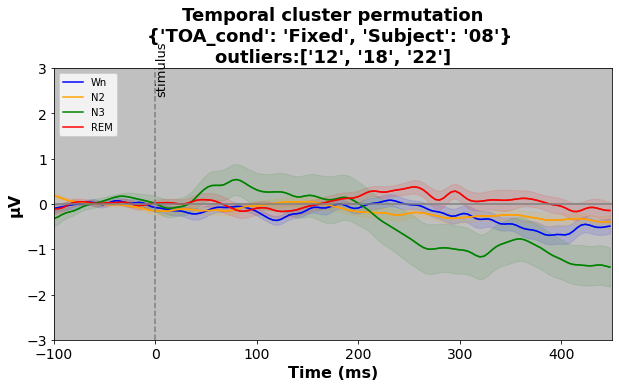

In [ ]:
contrasts = [['Wn','N2'],['Wn','N3'],['Wn','REM'],['N2','N3'],['N2','REM'],['REM','N3']]
contrastsColors = [['blue', 'orange'], ['blue', 'green'], ['blue', 'red'], ['orange', 'green'], ['orange', 'red'], ['red', 'green']]
contrastTypeName = 'Vigilance'
contrast_seperateVal = ['Wn','N2','N3','REM']
contrasts_sep_colors = ['blue', 'orange', 'green', 'red']

for TOA_cond in ['T','Rand','Fixed']:
    filters= {'TOA_cond':TOA_cond, 'Subject':'08'}
    filters_string = f"{filters}"

    ### get df cluster info
    with io.capture_output() as captured: # suppress output
        cluster_res = getClustersPerConditions(time0_i,contrastTypeName,contrasts,filters,test_per_voxel='ttest',perSubject=True)
        all_clust_df, sig_clust_df = get_clusters_dfs(contrasts,times[time0_i:],cluster_res)
    display(all_clust_df)
    display(sig_clust_df)

    ### plot clusters
    fig,ax1 = plt.subplots(1, 1, figsize=(10, 5))
    fig.patch.set_facecolor('xkcd:white')
    ax1 = get_evokedPerCond_ax(ax1, allEvents_df, contrastTypeName, contrast_seperateVal, filters, contrasts_sep_colors)
    get_contrasts_ax(ax1, contrasts, contrastsColors,cluster_res)
    applyDesign(fig, ax1,f'Temporal cluster permutation\n{filters_string} \noutliers:{cfg["outlier_subs"]}')

    plt.savefig(f'{fig_output_dir}/{TOA_cond}_allValidSubs_perVigi_5CentElect_wilcox.png')
    plt.show()

In [ ]:
# contrasts_sep_colors = ['#0f0f0f','#2f0f0f','#4f0f0f','#6f0f0f','#8f0f0f','#af0f0f','#cf0f0f','#ef0f0f','#ff0f0f']
# contrastsColors = [[contrasts_sep_colors[0], contrasts_sep_colors[1]],
#                    [contrasts_sep_colors[0], contrasts_sep_colors[2]],
#                    [contrasts_sep_colors[0], contrasts_sep_colors[3]],
#                    [contrasts_sep_colors[0], contrasts_sep_colors[4]],
#                    [contrasts_sep_colors[0], contrasts_sep_colors[5]],
#                    [contrasts_sep_colors[0], contrasts_sep_colors[6]],
#                    [contrasts_sep_colors[0], contrasts_sep_colors[7]],
#                    [contrasts_sep_colors[0], contrasts_sep_colors[8]]]
# contrastTypeName = 'ToneHeight'
# contrasts = [['650','845'],['650','1098'],['650','1428'],['650','1856'],['650','2413'],['650','3137'],['650','4079'],['650','5302']]
# contrast_seperateVal = ['650','845','1098','1428','1856','2413','3137','4079','5302']

# for TOA_cond in ['T','Rand','Fixed']:
#     filters= {'TOA_cond':TOA_cond}
#     filters_string = f"{filters}"

#     ### get df cluster info
#     with io.capture_output() as captured: # suppress output
#         cluster_res = getClustersPerConditions(time0_i,contrastTypeName,contrasts,filters)
#         all_clust_df, sig_clust_df = get_clusters_dfs(contrasts,times[time0_i:],cluster_res)
#         display(all_clust_df)
#         display(sig_clust_df)
#     ### plot clusters
#     fig,ax1 = plt.subplots(1, 1, figsize=(10, 5))
#     ax1 = get_evokedPerCond_ax(ax1, allEvents_df, contrastTypeName, contrast_seperateVal, filters, contrasts_sep_colors)
#     get_contrasts_ax(ax1, contrasts, contrastsColors,cluster_res)
#     applyDesign(ax1,f'Temporal cluster permutation\n{filters_string} \noutliers:{cfg["outlier_subs"]}')
#     plt.savefig(f'{fig_output_dir}/{TOA_cond}_allValidSubs_perToneH_5CentElect.png')